# Week 4 - Partial Least Squares Regression

**Please indicate at the top of your assignment whether or not you used any AI tools, such as MS Copilot. If you did use one of these tools, please provide a very brief explanation alongside each answer for how you confirmed the correctness of your solution.**

We will reimplement and then explore some of the properties of [Cosgrove et al](http://pubs.rsc.org/en/Content/ArticleLanding/2010/MB/b926287c).

no I did not use any ai tools

In [1]:
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt

data = sp.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

In [2]:
conditions

array(['DMSO_NoCyt', 'DMSO_IL-1', 'DMSO_LPS', 'DMSO_TNF', 'DMSO_IL-6',
       'DMSO_Mix', 'CIM_NoCyt', 'CIM_IL-1', 'CIM_LPS', 'CIM_TNF',
       'CIM_IL-6', 'CIM_Mix', 'RAN_NoCyt', 'RAN_IL-1', 'RAN_LPS',
       'RAN_TNF', 'RAN_IL-6', 'RAN_Mix', 'LEV_NoCyt', 'LEV_IL-1',
       'LEV_LPS', 'LEV_TNF', 'LEV_IL-6', 'LEV_Mix', 'TRO_NoCyt',
       'TRO_IL-1', 'TRO_LPS', 'TRO_TNF', 'TRO_IL-6', 'TRO_Mix',
       'BUS_NoCyt', 'BUS_IL-1', 'BUS_LPS', 'BUS_TNF', 'BUS_IL-6',
       'BUS_Mix', 'NEF_NoCyt', 'NEF_IL-1', 'NEF_LPS', 'NEF_TNF',
       'NEF_IL-6', 'NEF_Mix', 'ASP_NoCyt', 'ASP_IL-1', 'ASP_LPS',
       'ASP_TNF', 'ASP_IL-6', 'ASP_Mix', 'NIM_NoCyt', 'NIM_IL-1',
       'NIM_LPS', 'NIM_TNF', 'NIM_IL-6', 'NIM_Mix', 'CLA_NoCyt',
       'CLA_IL-1', 'CLA_LPS', 'CLA_TNF', 'CLA_IL-6', 'CLA_Mix',
       'TEL_NoCyt', 'TEL_IL-1', 'TEL_LPS', 'TEL_TNF', 'TEL_IL-6',
       'TEL_Mix'], dtype=object)

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principal components do you need for each to explain 90% of the Y variance? Discuss your findings.

Hint: Be sure you are normalizing each dataset as needed for the analysis.

4 componenets are needed to explain 90% of Y variance


Text(0, 0.5, 'Explained variance of Y')

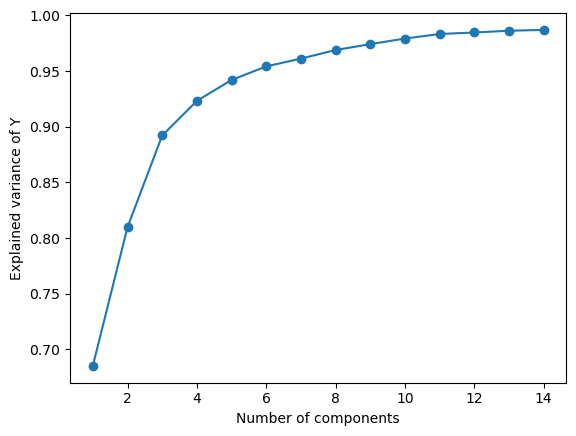

In [6]:
# Answer
# from sklearn.metrics import explained_variance_score, r2_score

standard_scaler = StandardScaler()
X_standardized = standard_scaler.fit_transform(X)
Y_standardized = standard_scaler.fit_transform(Y)[:,4]

explained_variance_all = []

n_components_min = 1
n_components_max = 15

switch = True

for n in range(n_components_min,n_components_max):
    plsr = PLSRegression(n_components=n)
     
    # Fit
    plsr.fit(X_standardized, Y_standardized)
    
    # # Predict
    # y_pred = plsr.predict(X_standardized)
    
    # Calculate the explained variance (r2y)
    explained_variance = plsr.score(X_standardized, Y_standardized) # Returns R-squared score
    explained_variance_all.append(explained_variance)

    if explained_variance >= 0.9 and switch:
        print(f"{n} componenets are needed to explain 90% of Y variance")
        switch = False


plt.plot(list(range(n_components_min,n_components_max)), explained_variance_all, "o-")

plt.xlabel("Number of components")
plt.ylabel("Explained variance of Y")

#### (2) How would you expect the percent of X variance explained to compare between PLSR and PCA? Why?

Percentage of X variance explained will be expected to be usually more in PCA especially in earlier components, since PCA will results in a strictly decreasing percent of X variance from 1st component to later components. It is because the primary purpose of PCA is to capture as much variance of X as possible by the components, regardless of response variable Y, by finding the direction along in which variance is maximized in X; PLSR aims to model the relationship between X and response variable Y, achieved by maximizing the covariance between X and response variable Y, so it does not necessarily find a component explaining variance of X by a lot especially when compared to early components of PCA.


#### (3) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

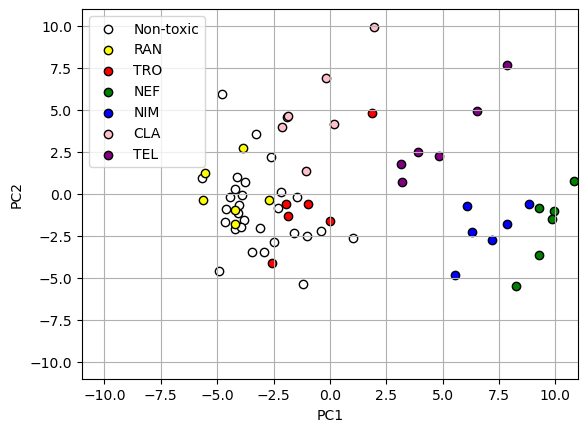

In [13]:
# Answer
from itertools import compress

plsr = PLSRegression(n_components=2)
# Fit
plsr.fit(X_standardized, Y_standardized)
# Predict
y_pred = plsr.predict(X_standardized)

scores = plsr.x_scores_

conditions_clean = [x[0:x.find("_")] for x in conditions]
# dict_drug_toxic = dict(zip(drugList, drugListToxic))
drugList_toxic = drugList[drugListToxic==1]
# new drug list and conditions list by grouping non-toxic into one group
drugList_new = [x if x in drugList_toxic else "Non-toxic" for x in drugList]
conditions_new = [x if x in drugList_toxic else "Non-toxic" for x in conditions_clean]


# Create the score plot
labels=["Non-toxic"] + [x for x in drugList_new if x != "Non-toxic"]
color_map = dict(zip(labels, ["White", "Yellow", "Red", "Green", "Blue", "Pink", "Purple"]))


for label in labels:
    selectors = [x == label for x in conditions_new]
    score_0 = list(compress(scores[:, 0], selectors))
    score_1 = list(compress(scores[:, 1], selectors))
    plt.scatter(score_0, score_1, label=label, c=color_map[label], edgecolors= "black")
    
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.grid()

#### (4) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

Some phosphoproteins farther away from the origin have a greater contribution on the principal components and more relevant to the prediction. For example, p-p70 S6K and p-Akt negatively influences PC1 the most in general; p-MEK1 and p-ERK1/2 positively influences PC2 the most in general; p-p38 and p-HSP27 positively incluences PC1 the most in general.

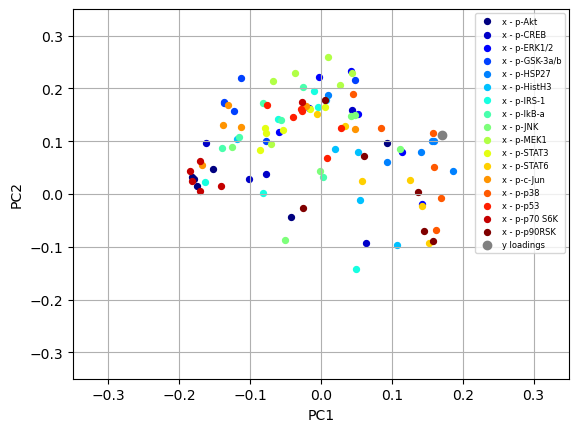

In [20]:
# Answer


phosphoproteins_clean = [x[0:x.find("_")] for x in phosphoproteins]
phosphoproteins_clean_unique = np.unique(phosphoproteins_clean)

x_loadings = plsr.x_loadings_
y_loadings = plsr.y_loadings_

colors = plt.cm.jet(np.linspace(0,1,len(phosphoproteins_clean_unique)))# Initialize holder 

# Create the loading plot
for n, label in enumerate(phosphoproteins_clean_unique):
    selectors = [x == label for x in phosphoproteins_clean]
    loadings_0 = list(compress(x_loadings[:, 0], selectors))
    loadings_1 = list(compress(x_loadings[:, 1], selectors))
    plt.scatter(loadings_0, loadings_1, label="x - "+label, color=colors[n], s=18)
    
plt.scatter(y_loadings[:, 0], y_loadings[:, 1], label="y loadings", color='grey')
    
plt.xlabel('PC1')
plt.ylabel('PC2')
# larger scale to accomodate legend
plt.xlim(-0.35, 0.35)
plt.ylim(-0.35, 0.35)
plt.legend(prop={'size': 6})
plt.grid()

#### (5) Add the variance of the loadings to your loadings plot (this can be shown as error bars). How does the variance of component one compare to that of component two? Would you expect a trend in the general variance versus component number?

Variance of component one is in general smaller than that of component 2. I expect the general trend of variance of loadings will first increase along increasing component number, followed by a decline or plateau when adding further components does not help to explain much.

In [24]:
# Answer.
from sklearn.utils import resample

rounds = 100
loading_1_all = []
loading_2_all = []
scoring_1_all = []
scoring_2_all = []

for x in range(rounds):
    resamp = resample(range(Y.shape[0]))
    X_samp = X[resamp]
    Y_samp = Y[resamp]
    standard_scaler = StandardScaler()
    X_standardized_samp = standard_scaler.fit_transform(X_samp)
    Y_standardized_samp = standard_scaler.fit_transform(Y_samp)[:,4]

    plsr = PLSRegression(n_components=2)
    plsr.fit(X_standardized_samp, Y_standardized_samp)
    
    loadings_samp = plsr.x_loadings_
    loading_1_all.append(loadings_samp[:,0])
    loading_2_all.append(loadings_samp[:,1])

    scorings_samp = plsr.x_scores_
    scoring_1_all.append(scorings_samp[:,0])
    scoring_2_all.append(scorings_samp[:,1])

print(np.mean(np.var(loading_1_all, axis=0)))
print(np.mean(np.var(loading_2_all, axis=0)))
# print(np.var(scoring_1_all, axis=0))
# print(np.var(scoring_2_all, axis=0))

0.006987505666483962
0.01131843916586527


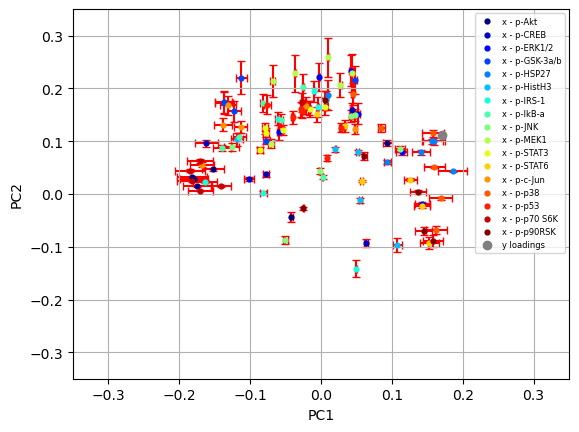

In [26]:
colors = plt.cm.jet(np.linspace(0,1,len(phosphoproteins_clean_unique)))# Initialize holder 

# Create the loading plot
for n, label in enumerate(phosphoproteins_clean_unique):
    selectors = [x == label for x in phosphoproteins_clean]
    loadings_0 = list(compress(x_loadings[:, 0], selectors))
    loadings_1 = list(compress(x_loadings[:, 1], selectors))
    loadings_d_pc1 = list(compress(np.var(loading_1_all, axis=0), selectors))
    loadings_d_pc2 = list(compress(np.var(loading_2_all, axis=0), selectors))
    plt.scatter(loadings_0, loadings_1, label="x - "+label, color=colors[n], s=12, zorder=10)
    plt.errorbar(loadings_0, loadings_1, xerr=loadings_d_pc1, yerr=loadings_d_pc2, color='r', linestyle='', capsize=3,zorder=1)
    
plt.scatter(y_loadings[:, 0], y_loadings[:, 1], label="y loadings", color='grey')
    
plt.xlabel('PC1')
plt.ylabel('PC2')
# larger scale to accomodate legend
plt.xlim(-0.35, 0.35)
plt.ylim(-0.35, 0.35)
plt.legend(prop={'size': 6})
plt.grid()

In [28]:
# # Create the score plot
# labels=["Non-toxic"] + [x for x in drugList_new if x != "Non-toxic"]
# color_map = dict(zip(labels, ["White", "Yellow", "Red", "Green", "Blue", "Pink", "Purple"]))


# for label in labels:
#     selectors = [x == label for x in conditions_new]
#     score_0 = list(compress(scores[:, 0], selectors))
#     score_1 = list(compress(scores[:, 1], selectors))
#     score_d_pc1 = list(compress(np.var(scoring_1_all, axis=0), selectors))
#     score_d_pc2 = list(compress(np.var(scoring_2_all, axis=0), selectors))
#     plt.scatter(score_0, score_1, label=label, c=color_map[label], edgecolors= "black")
#     plt.errorbar(score_0, score_1, xerr=score_d_pc1, fmt='r-', capsize=5)
#     plt.errorbar(score_0, score_1, yerr=score_d_pc2, fmt='r-', capsize=5)
    
# plt.legend()
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
# plt.grid()


#### (6) Recreate a 4-principal component model using PLSR with just the final 4 phosphoprotein model. Plot predicted v. observed LDH for this model. Report the model fitness ($R^2$). Define here how you are calculating $R^2$.

Calculate R2 by subtracting sum of squared errors from the total sum of squares. Calculating by this manual method matches with sklearn r2_score function. 

R2 score:0.8821898904528919
R2 score:0.8821898904528919
R2 score by manual method:0.8821898904528919


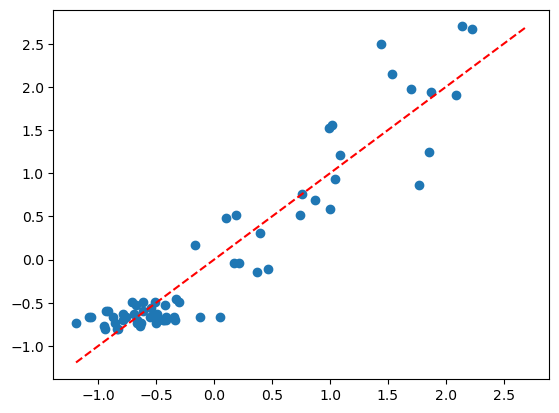

In [32]:
# Answer
from sklearn.metrics import r2_score

# 4 phosphoprotein
plsr = PLSRegression(n_components=4)
# Fit

X_standardized_4P = X_standardized[:,ind4pProtein]
plsr.fit(X_standardized_4P, Y_standardized)

# Predict
y_pred = plsr.predict(X_standardized_4P)
plt.plot(y_pred, Y_standardized, "o")

# ref line
min_ref = min(np.concatenate((y_pred, Y_standardized)))
max_ref = max(np.concatenate((y_pred, Y_standardized)))
plt.plot([min_ref,max_ref], [min_ref,max_ref], "r--")

# R2 score
print("R2 score:{}".format(plsr.score(X_standardized_4P, Y_standardized)))
print("R2 score:{}".format(r2_score(Y_standardized, y_pred)))

ss_residual = np.sum((Y_standardized - y_pred) ** 2)
ss_total = np.sum((Y_standardized - np.mean(Y_standardized)) ** 2)

r_score = 1 - (ss_residual / ss_total)
print("R2 score by manual method:{}".format(r_score))

R2 score:0.923198313533617
R2 score by manual method:0.923198313533617


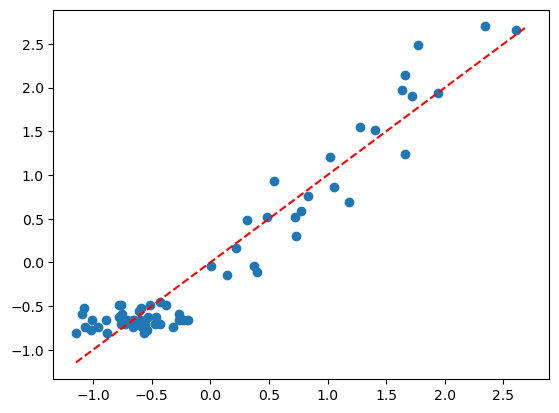

In [34]:
# all phosphoprotein
plsr = PLSRegression(n_components=4)
# Fit

plsr.fit(X_standardized, Y_standardized)

# Predict
y_pred = plsr.predict(X_standardized)
plt.plot(y_pred, Y_standardized, "o")

# ref line
min_ref = min(np.concatenate((y_pred, Y_standardized)))
max_ref = max(np.concatenate((y_pred, Y_standardized)))
plt.plot([min_ref,max_ref], [min_ref,max_ref], "r--")

# R2 score
print("R2 score:{}".format(r2_score(Y_standardized, y_pred)))

ss_residual = np.sum((Y_standardized - y_pred) ** 2)
ss_total = np.sum((Y_standardized - np.mean(Y_standardized)) ** 2)

r_score = 1 - (ss_residual / ss_total)
print("R2 score by manual method:{}".format(r_score))

#### (7) Cosgrove *et al* discusses their method for model validation using leave-one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

It is important to perform cross-validation to know how well the model is done. Taking R2 score based on whole training test cannot give an accurate result since the model is both fit and tested on the same data, leading to information leakage. This is illustrated by above R2 score higher than below R2 score. Cross validation is useful to evaluate how well the model performs on unseen data and especially helpful when number of records is very small (66 in this case) that we want to full utilize data and do not want to entirely separate a testing dataset, and averaging effect avoids giving a evaluation merely based on an extreme data. This is an ideal tool when deciding number of components needed since using R2 score based on training data will always be overfitting and increasing along number of components.

In [38]:
# Answer
cv = LeaveOneOut()

y_true_all = []
y_pred_all = []


for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    Y_train, Y_test = Y[train_ix], Y[test_ix]

    standard_scaler = StandardScaler()
    X_train_standardized = standard_scaler.fit_transform(X_train)
    X_test_standardized = standard_scaler.transform(X_test)
    Y_train_standardized = standard_scaler.fit_transform(Y_train)[:,4]
    Y_test_standardized = standard_scaler.transform(Y_test)[:,4]

    plsr = PLSRegression(n_components=4)
    # Fit
    plsr.fit(X_train_standardized, Y_train_standardized)
    
    # Predict
    y_pred = plsr.predict(X_test_standardized)

    y_true_all.append(*Y_test_standardized)
    y_pred_all.append(*y_pred)


In [40]:

# R2 score
print("R2 score:{}".format(r2_score(y_true_all, y_pred_all)))

ss_residual = np.sum((np.subtract(y_true_all, y_pred_all)) ** 2)
ss_total = np.sum((y_true_all - np.mean(y_true_all)) ** 2)

r_score = 1 - (ss_residual / ss_total)
print("R2 score by manual method:{}".format(r_score))

R2 score:0.8566568252556501
R2 score by manual method:0.8566568252556501


#### (8) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

It slightly decrease the evaluation score but still similar when compared with leave one out method. LOOCV is better when the data size is very small and we want to use more data for training during the CV process, or when grouping is not obvious in the data. LOGO is better when grouping is obvious in the data and we want to evaluate average performance on different groups, and it is also less computationally expensive.

In [44]:
# Answer
arr = np.array([0, 1, 2, 3, 4, 5])
idx_group = np.tile(arr, 11)


score_all = []

logo = LeaveOneGroupOut()

# Iterate through the splits
for train_ix, test_ix in logo.split(X, Y, idx_group):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    Y_train, Y_test = Y[train_ix], Y[test_ix]

    standard_scaler = StandardScaler()
    X_train_standardized = standard_scaler.fit_transform(X_train)
    X_test_standardized = standard_scaler.transform(X_test)
    Y_train_standardized = standard_scaler.fit_transform(Y_train)[:,4]
    Y_test_standardized = standard_scaler.transform(Y_test)[:,4]

    plsr = PLSRegression(n_components=4)
    # Fit
    plsr.fit(X_train_standardized, Y_train_standardized)
    
    # Predict
    y_pred = plsr.predict(X_test_standardized)

    q2 = r2_score(Y_test_standardized, y_pred)
    score_all.append(q2)

print("Cross validation score: {}".format(np.mean(score_all)))

Cross validation score: 0.8532890961574613
